In [1]:
%matplotlib widget
from typing import Dict

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

# Dynamic Programming (DP) vs Monte Carlo (MC) vs Temporal Difference (TD)

In this example, the agent starts from state 3, and always takes a 50/50 action between moving left or right. The state 0 and 6 are terminal states, and moving from state 5 to 6 gives the agent a reward of +1. The discount factor $\gamma$ is 1. As such, this is an episodic task. We will use 3 different approaches: Dynamic Programming (DP), Monte Carlo (MC), and Temporal Difference to solve for the state values.

![title](../images/dp_mc_td_example.png)

## DP solution

To solve for the state values with DP, we need to specific the state transition probability under the current policy (50/50 random), and the reward. The transisition probability matrix $P$ can be written as:

$$
  P = 
  \begin{bmatrix}
  0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  1 & 0 & 1 & 0 & 0 & 0 & 0 \\
  0 & 1 & 0 & 1 & 0 & 0 & 0 \\
  0 & 0 & 1 & 0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 1 & 0 \\
  0 & 0 & 0 & 0 & 1 & 0 & 1 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0
  \end{bmatrix} 
$$
and the reward $R$ can be written as
$$
  R = 
  \begin{bmatrix}
  0 & 0 & 0 & 0 & 0 & 0 & 1
  \end{bmatrix}
$$

As such, the state value $V(s)$ can be written (via DP) as:

$$
V = P(R + \gamma V)
$$
and solved via:

$$
V = (I - \gamma P)^{-1} P R 
$$

In [2]:
proba = 0.5 * np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0],
])

rewards = np.array([0, 0, 0, 0, 0, 0, 1]).T

state_values_dp: Dict = {i: x for i, x in enumerate(np.linalg.inv(np.eye(N=7) - proba) @ proba @ rewards)}
state_values_dp

{0: 0.0,
 1: 0.16666666666666666,
 2: 0.3333333333333333,
 3: 0.5,
 4: 0.6666666666666667,
 5: 0.8333333333333334,
 6: 0.0}

## MC solution

Since this is an episodic task, we can solve it using MC. Recall that in MC, we allow the episode to run until it terminates, while keeping the record of the visited states and collected rewards. Once the episode is terminated, we update each state's value from the **back**. Here we will use the first visit MC.

In [3]:
n_episodes = 100
gamma = 1

def get_state_values_mc(n_episodes: int, gamma: int) -> Dict:
    """Calculates the state values using Monte Carlo."""

    state_rewards = {i: [0.5, ] for i in range(7)}
    for s in (0, 6):
        state_rewards[s] = [0, ]
    for _ in range(n_episodes):
        current_state = 3  # Starting state 
        step = 0
        first_visit = {current_state: 0}

        state_history = [current_state]
        reward_history = [0]

        while current_state not in (0, 6):
            step += 1
            next_state = current_state + np.random.choice([-1, 1])
            if not next_state in first_visit:
                first_visit[next_state] = step

            state_history.append(next_state)
            if next_state == 6:
                reward_history.append(1)
            else:
                reward_history.append(0)

            current_state = next_state 

        # Makes updates from the end of the episode
        total_reward = 0
        for i in range(step, -1, -1):
            total_reward = (reward_history[i] + gamma * total_reward)
            # Is this the first visit?
            if first_visit[state_history[i]] == i:
                state_rewards[state_history[i]].append(total_reward)

    state_values_mc = {k: np.mean(v) for k, v in state_rewards.items()}
    return state_values_mc

get_state_values_mc(n_episodes=n_episodes, gamma=gamma)

{0: 0.0,
 1: 0.19166666666666668,
 2: 0.37012987012987014,
 3: 0.5198019801980198,
 4: 0.6730769230769231,
 5: 0.8333333333333334,
 6: 0.9811320754716981}

## TD

In TD, we update a state's value immediately after we have moved on to the next state and collected the reward. The update rule of the state value can be thought as adding a correction term (TD error) to the previous estimate of the state value.

In [4]:
def get_state_values_td(n_episodes: int, gamma: int, alpha: float = 0.1) -> Dict:
    """Calculates the state values using Temporal Difference."""  
    
    state_values_td = {i: 0.5 for i in range(7)}
    for s in (0, 6):
        state_values_td[s] = 0
    for _ in range(n_episodes):
        current_state = 3  # Starting state 

        while current_state not in (0, 6):
            next_state = current_state + np.random.choice([-1, 1])
            reward = 1 if next_state == 6 else 0

            state_values_td[current_state] += alpha * (reward + gamma * state_values_td[next_state] - state_values_td[current_state])
            current_state = next_state

    return state_values_td

get_state_values_td(n_episodes=n_episodes, gamma=gamma)

{0: 0,
 1: 0.07340779785603573,
 2: 0.3173164087763114,
 3: 0.49148077436331333,
 4: 0.629538237498324,
 5: 0.7770901694063482,
 6: 0}

In [5]:
mc, td = [], []
mc_rmse, td_rmse = [], [] 
state_values_true = [state_values_dp[s] for s in range(1, 6)]

results = pd.DataFrame(columns=["trial_idx", "n_episode", "method", "rmse"])

for i in tqdm(range(1, 50)):
    for n in range(1, 101):
        state_values_mc = get_state_values_mc(n_episodes=n, gamma=gamma)
        state_values_td = get_state_values_td(n_episodes=n, gamma=gamma, alpha=.2)
        
        results = pd.concat([
            results, 
            pd.DataFrame(data={
                "trial_idx": [i] * 2,
                "n_episode": [n] * 2, 
                "method": ["MC", "TD"],
                "rmse": [
                    mean_squared_error(state_values_true, [state_values_mc[s] for s in range(1, 6)], squared=False),
                    mean_squared_error(state_values_true, [state_values_td[s] for s in range(1, 6)], squared=False)
                ]
            })
            
        ])

results = results.reset_index(drop=True)

  0%|          | 0/49 [00:00<?, ?it/s]

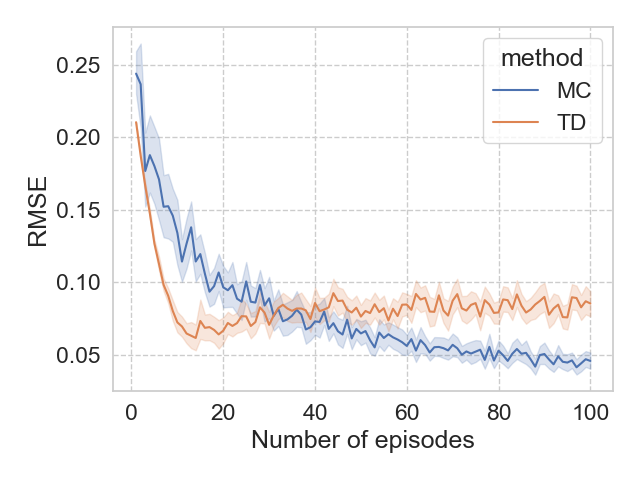

In [6]:
ax = sns.lineplot(x="n_episode", y="rmse", hue="method", data=results)
ax.set_xlabel("Number of episodes")
ax.set_ylabel("RMSE")

plt.tight_layout()